In [56]:
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
import pandas as pd
import json
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv('triplet.csv')

In [ ]:
class LinearAdapter(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return self.linear(x)

In [69]:
class TripletDataset(Dataset):
    def __init__(self, data):
        self.anchors = data["anchor"].values
        self.positives = data["pos"].values
        self.negatives = data["neg"].values

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self, idx):
        anchor = torch.tensor(json.loads(self.anchors[idx]))
        pos = torch.tensor(json.loads(self.positives[idx]))
        neg = torch.tensor(json.loads(self.negatives[idx]))
           
        return anchor, pos, neg

In [76]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))
    return LambdaLR(optimizer, lr_lambda)

def train_linear_adapter(train_data, num_epochs=10, batch_size=32, 
                         learning_rate=2e-5, warmup_steps=100, max_grad_norm=1.0, margin=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    adapter = LinearAdapter(768).to(device)

    triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y), margin=margin)
    optimizer = AdamW(adapter.parameters(), lr=learning_rate)

    dataset = TripletDataset(train_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_steps = len(dataloader) * num_epochs
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    losses = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            anchor_emb, positive_emb, negative_emb = [x.to(device) for x in batch]
            
            # Forward pass
            adapted_anchor_emb = adapter(anchor_emb)
            adapted_pos_emb = adapter(positive_emb)
            adapted_neg_emb = adapter(negative_emb)
            
            # Compute loss
            loss = triplet_loss(adapted_anchor_emb, adapted_pos_emb, adapted_neg_emb)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            clip_grad_norm_(adapter.parameters(), max_grad_norm)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        l = total_loss/len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {l:.4f}")
        losses.append(l)

    
    return adapter, losses

In [77]:
# Define the kwargs dictionary
adapter_kwargs = {
    'num_epochs': 30,
    'batch_size': 64,
    'learning_rate': 0.005,
    'warmup_steps': 100,
    'max_grad_norm': 1.0,
    'margin': 1.0
}

# Train the adapter using the kwargs dictionary
trained_adapter, losses = train_linear_adapter(df, **adapter_kwargs)

# Create a dictionary to store both the adapter state_dict and the kwargs
save_dict = {
    'adapter_state_dict': trained_adapter.state_dict(),
    'adapter_kwargs': adapter_kwargs
}

# Save the combined dictionary
torch.save(save_dict, f'non_linear_adapter_30_epochs.pth')

Epoch 1/30, Loss: 1.0524
Epoch 2/30, Loss: 1.0161
Epoch 3/30, Loss: 0.9812
Epoch 4/30, Loss: 0.9363
Epoch 5/30, Loss: 0.6612
Epoch 6/30, Loss: 0.4183
Epoch 7/30, Loss: 0.2638
Epoch 8/30, Loss: 0.1792
Epoch 9/30, Loss: 0.1218
Epoch 10/30, Loss: 0.0758
Epoch 11/30, Loss: 0.0612
Epoch 12/30, Loss: 0.0451
Epoch 13/30, Loss: 0.0265
Epoch 14/30, Loss: 0.0174
Epoch 15/30, Loss: 0.0133
Epoch 16/30, Loss: 0.0139
Epoch 17/30, Loss: 0.0167
Epoch 18/30, Loss: 0.0063
Epoch 19/30, Loss: 0.0036
Epoch 20/30, Loss: 0.0028
Epoch 21/30, Loss: 0.0030
Epoch 22/30, Loss: 0.0026
Epoch 23/30, Loss: 0.0020
Epoch 24/30, Loss: 0.0007
Epoch 25/30, Loss: 0.0010
Epoch 26/30, Loss: 0.0039
Epoch 27/30, Loss: 0.0034
Epoch 28/30, Loss: 0.0023
Epoch 29/30, Loss: 0.0008
Epoch 30/30, Loss: 0.0001


Text(0, 0.5, 'Loss')

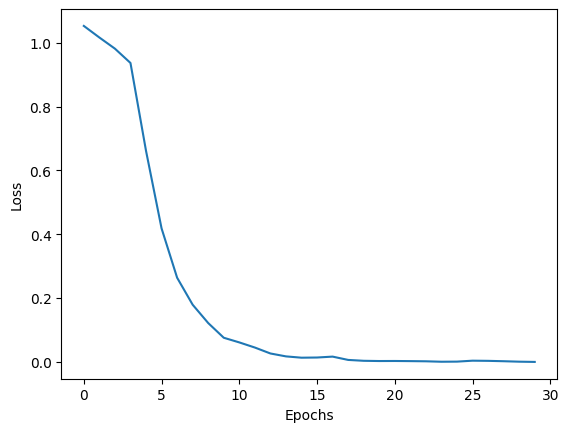

In [78]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")